# Examine model
We want to examine how the mikenet model works by checking:
1. Whether Chang's weights produce HS04 fig. 12 result
2. What are the Input **direction** and **magnitude**

In [1]:
import os
import tensorflow as tf
import numpy as np
import meta, modeling, evaluate
os.chdir(os.environ.get("TF_ROOT"))

## Restore to Chang's weights

In [2]:
cfg = meta.Config.from_json('models/surgery/model_config.json')
model = modeling.MyModel(cfg)
model.build()
ckpt = tf.train.Checkpoint(model=model)
ckpt.restore(os.path.join(cfg.checkpoint_folder,'epoch-1'))
[print(f'{w.name} mean: {w.numpy().mean()}') for w in model.weights]

Loaded config from models/surgery/model_config.json


2021-11-12 20:15:26.792231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-12 20:15:26.799521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-12 20:15:26.799910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2021-11-12 20:15:26.800649: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

w_hsp_sh:0 mean: -0.036436256021261215
w_hsp_hp:0 mean: -0.15658600628376007
w_pc:0 mean: -0.09082742780447006
w_cp:0 mean: -0.38210487365722656
bias_hsp:0 mean: -2.535120964050293
bias_p:0 mean: -3.783306837081909
bias_cpp:0 mean: -2.9965076446533203
w_hps_ph:0 mean: -0.14618974924087524
w_hps_hs:0 mean: -0.18353353440761566
w_sc:0 mean: -0.03645188361406326
w_cs:0 mean: -0.3741818368434906
bias_hps:0 mean: -2.2887043952941895
bias_s:0 mean: -3.3815836906433105
bias_css:0 mean: -1.3210525512695312
w_hos_oh:0 mean: -0.048883236944675446
w_hos_hs:0 mean: -0.0537002868950367
bias_hos:0 mean: -3.338172197341919
w_hop_oh:0 mean: -0.032783929258584976
w_hop_hp:0 mean: -0.09362849593162537
bias_hop:0 mean: -2.79338002204895


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

## Test with mn_r100 testset

In [3]:
mn_r100 = evaluate.load_testset('mn_r100')
model.set_active_task('triangle')
y_pred = model([mn_r100['ort']] * 12)

2021-11-12 20:15:29.232337: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


![HS04 figure 12](/triangle_model/references/hs04_fig12.png)

## Checking the sparse representation still looks good

In [4]:
def dense_to_sparse(dense: np.array) -> list:
    """Convert dense representation to sparse representation."""
    sparse = []
    for i, unit in enumerate(dense):
        if unit == 1:
            sparse.append(i)
    return sparse

def word_to_sparse(testset: dict, word: str) -> dict:
    """Convert word to sparse representation."""
    word_idx = testset['item'].index(word)
    return {f"{x}: {dense_to_sparse(mn_r100[x][word_idx])}" for x in ['ort', 'pho', 'sem']}


word_to_sparse(mn_r100, 'close')

{'ort: [54, 89, 118, 174, 186]',
 'pho: [29, 31, 52, 60, 62, 87, 90, 92, 94, 96, 102, 107]',
 'sem: [4, 6, 29, 46, 49, 104, 209, 236, 813, 913, 1148]'}

In [5]:
# TF style naming to HS04 naming for reference

name_map = {
    'input_hos_hs': 'OS',
    'input_hop_hp': 'OP',
    'input_hps_hs': 'PS',
    'input_css_cs': 'CS'
}

In [6]:
sem = tf.cast([mn_r100['sem']] * 13, tf.float32)
pho = tf.cast([mn_r100['pho']] * 13, tf.float32)

In [7]:
def get_inputs(y: tf.Tensor, mask: tf.Tensor) -> list:
    """Get the input over time tick.
    Assumed dimensions equal between y and mask:
        y: (timetick, word, unit)
    """
    assert y.shape == mask.shape
    masked_y = mask * y
    mean_y = tf.reduce_sum(masked_y, axis=2) / tf.reduce_sum(mask, axis=2)  # Average over unit (node) dimension
    return tf.reduce_mean(mean_y, axis=1).numpy().tolist()

In [8]:
from metrics import CosineSemanticAccuracy
acc = CosineSemanticAccuracy()
acc(y_true=tf.cast(mn_r100['sem'], tf.float32), y_pred=y_pred['sem'][-2])

2021-11-12 20:15:30.200001: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 114688048 exceeds 10% of free system memory.


<tf.Tensor: shape=(), dtype=float32, numpy=0.76>

In [9]:
# Raw input before TAI
op = get_inputs(y_pred['input_hop_hp'], mask=pho)
os = get_inputs(y_pred['input_hos_hs'], mask=sem)
ps = get_inputs(y_pred['input_hps_hs'], mask=sem)
cs = get_inputs(y_pred['input_css_cs'], mask=sem)

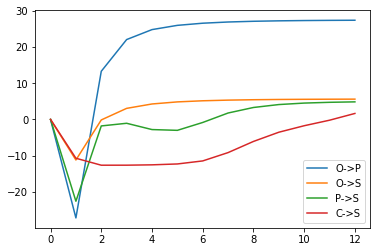

In [10]:
import matplotlib.pyplot as plt
plt.plot(op, label='O->P')
plt.plot(os, label='O->S')
plt.plot(ps, label='P->S')
plt.plot(cs, label='C->S')
plt.legend(loc="lower right")
plt.show()

# Double check with old codes

In [18]:
import pandas as pd

layer = 'sem'
target_word = 'close'
target_word_idx = mn_r100['item'].index(target_word)
bias_name = 'bias_s'

df_dict = {}
df_dict["target_act"] = mn_r100[layer][target_word_idx, :]
df_dict["bias"] = [w.numpy() for w in model.weights if w.name.startswith(bias_name)][0]
df_time_invar = pd.DataFrame.from_dict(df_dict)
df_time_invar["unit"] = df_time_invar.index
df_time_invar["word"] = target_word
df_time_invar

,target_act,bias,unit,word
0,0.0,-2.634219,0,close
1,0.0,-2.103109,1,close
2,0.0,-1.273724,2,close
3,0.0,-2.099038,3,close
4,1.0,-1.837062,4,close
...,...,...,...,...
2441,0.0,-4.272089,2441,close
2442,0.0,-3.797071,2442,close
2443,0.0,-4.257431,2443,close
2444,0.0,-4.691223,2444,close


In [19]:
SEM_NAME_MAP = {
    "input_hps_hs": "PS",
    "input_css_cs": "CS",
    "input_sem": "SS",
    "input_hos_hs": "OS",
    "input_sem": "input",
    "sem": "act",
}
PHO_NAME_MAP = {
    "input_hsp_hp": "SP",
    "input_cpp_cp": "CP",
    "input_pho_pp": "PP",
    "input_hop_hp": "OP",
    "input_pho": "input",
    "pho": "act",
}

name_map = SEM_NAME_MAP

df_time_varying = pd.DataFrame()

for i, model_output_name in enumerate(name_map.keys()):
    this_output_df = pd.DataFrame()
    for t in range(13):
        df_dict = {}
        name = name_map[model_output_name]
        df_dict[name] = y_pred[model_output_name][t, target_word_idx, :]
        this_step_df = pd.DataFrame.from_dict(df_dict)
        this_step_df["timetick"] = t
        this_step_df["unit"] = this_step_df.index
        this_output_df = pd.concat([this_output_df, this_step_df], ignore_index=True)

    if i == 0:
        df_time_varying = this_output_df
    else:
        df_time_varying = pd.merge(
            df_time_varying, this_output_df, on=["timetick", "unit"]
        )

df_time_varying

,PS,timetick,unit,CS,input,OS,act
0,0.000000,0,0,0.000000,0.000000,0.000000,5.000000e-01
1,0.000000,0,1,0.000000,0.000000,0.000000,5.000000e-01
2,0.000000,0,2,0.000000,0.000000,0.000000,5.000000e-01
3,0.000000,0,3,0.000000,0.000000,0.000000,5.000000e-01
4,0.000000,0,4,0.000000,0.000000,0.000000,5.000000e-01
...,...,...,...,...,...,...,...
31793,-8.519194,12,2441,-3.174736,-18.039394,-1.104074,1.464167e-08
31794,-5.844481,12,2442,-4.165694,-19.237715,-4.696007,4.417399e-09
31795,-4.823146,12,2443,-6.466595,-16.089689,-1.220229,1.028814e-07
31796,-11.020306,12,2444,-7.732808,-24.176319,-1.993777,3.164885e-11


### Any on prediction?

In [20]:
df_time_varying.loc[df_time_varying.act>0.5]

,PS,timetick,unit,CS,input,OS,act
24479,11.745820,10,19,-0.030493,1.627385,2.086039,0.835811
25461,5.161246,10,1001,-4.242477,1.208126,10.286044,0.769967
26925,12.213028,11,19,1.071834,5.633402,2.138830,0.996436
26930,2.940341,11,24,2.084994,0.285334,4.390696,0.570854
27907,5.228791,11,1001,-2.775637,4.246756,10.304584,0.985891
29371,12.434217,12,19,2.553104,8.883276,2.173959,0.999861
29376,3.157211,12,24,7.239064,4.476071,4.410080,0.988750
30353,5.268645,12,1001,-1.098093,6.849111,10.316992,0.998941


In [21]:
# Merge and export
df = df_time_varying.merge(df_time_invar, on="unit", how="left")
df["unit_acc"] = abs(df.target_act - df.act) < 0.5
df = df[
    ["word", "unit", "unit_acc", "timetick", "target_act", "bias"]
    + list(name_map.values())
]

# Restructure
melt_value_vars = ["bias"] + list(name_map.values())
df = df.melt(
    id_vars=["word", "unit", "timetick", "target_act", "unit_acc"],
    value_vars=melt_value_vars,
)

In [22]:
all_on_nodes = df.loc[df.target_act == 1, "unit"].unique()
all_off_nodes = df.loc[df.target_act == 0, "unit"].unique()
print(f"On: {all_on_nodes} \nOff: {np.random.choice(all_off_nodes, 10)}")

On: [   4    6   29   46   49  104  209  236  813  913 1148] 
Off: [1448 1288 1750 2289 1118 2330 1465  908 1476 2014]


In [23]:
import altair as alt
sel_node = all_on_nodes
node_df = df.loc[df.unit.isin(sel_node)]
plot_df = node_df.loc[~node_df.variable.isin(['act', 'input', 'SS', 'PP'])]

alt.Chart(plot_df).mark_line().encode(
    y='mean(value):Q', 
    x='timetick:Q', 
    color='variable:N'
    ).properties(title=f"word: {target_word} at nodes: {sel_node}")

alt.Chart(...)

## EoT acc

In [12]:
from scipy.spatial.distance import cosine

In [13]:
import data_wrangling
def min_cosine_distance_idx(all_reps, pred):
    """return the index of word that has min cosine distance"""
    all_cosine_dist = [cosine(pred, rep) for rep in all_reps]
    return np.argmin(all_cosine_dist) 

def cosine_accuracy(all_reps, pred, target):
    """Check whether the prediction is the min cosine distance word"""
    target_idx = min_cosine_distance_idx(all_reps, target)
    pred_idx = min_cosine_distance_idx(all_reps, pred)
    return target_idx == pred_idx

def all_cosine_accuracy(all_reps, preds, targets):
    return np.mean([cosine_accuracy(all_reps, pred, target) for pred, target in zip(preds, targets)])

def binary_accuracy(pred, target):
    """Calculate correct side accuracy"""
    d = abs(pred - target)
    max_d = np.max(d, axis = 1)
    # print(max_d)
    return np.mean(max_d < 0.5)

def get_all_acc(y_pred):
    """Calculate accuracy of all outputs"""
    mn_train = data_wrangling.load_testset('mn_r100')
    sem_acc = all_cosine_accuracy(all_reps=mn_train['sem'], preds=y_pred['sem'][-1].numpy(), targets=mn_train['sem'])
    pho_acc = binary_accuracy(mn_r100['pho'], y_pred['pho'][-1, :, :].numpy())
    return {
        "pho": pho_acc,
        "sem": sem_acc
    }

def get_task_acc(task):
    """Get task acc"""
    model.set_active_task(task)
    input_name = modeling.IN_OUT[task][0]
    y_pred = model([mn_r100[input_name]] * cfg.n_timesteps)
    return get_all_acc(y_pred)

In [17]:
[print(f"{x}: {get_task_acc(x)}") for x in ['triangle', 'ort_pho', 'ort_sem', 'exp_osp', 'exp_ops']]

triangle: {'pho': 0.96, 'sem': 0.94}


/opt/conda/lib/python3.7/site-packages/scipy/spatial/distance.py:699: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


ort_pho: {'pho': 0.96, 'sem': 0.01}
ort_sem: {'pho': 0.0, 'sem': 0.56}
exp_osp: {'pho': 0.0, 'sem': 0.23}
exp_ops: {'pho': 0.96, 'sem': 0.51}


[None, None, None, None, None]